In [10]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import hog
from skimage import exposure
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import exposure
from skimage import color
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from skimage.transform import resize

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [5]:
def preprocess_image(image_array):
    # Convert the image to grayscale if it's in color
    if image_array.shape[-1] == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(image_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return adaptive_thresh

def detect_suit_regions_with_box(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to grayscale and apply adaptive thresholding
    suit_image = preprocess_image(image_rgb)

    # Convert the image to binary using Otsu's thresholding.
    # Otsu's thresholding divides the pixels of the image into two classes: foreground and background.
    # Helps isolate region of interest for feature extraction
    _, binary_image = cv2.threshold(suit_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Erode the binary image to enhance the suits.
    # Eroding reduces the size of the white regions of the foreground.
    eroded_image = cv2.erode(binary_image, None, iterations=2)

    # Find contours, the outlines that have the same intensity, in the eroded image.
    contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours are detected.
    # If not, then return None
    if not contours:
        print(f"No suit regions detected for {image_path}")
        return None, None

    # Find the largest contour, assuming it corresponds to the suit region.
    suit_contour = max(contours, key=lambda x: cv2.contourArea(x))

    # Get the bounding box of the suit contour.
    x, y, w, h = cv2.boundingRect(suit_contour)

    # Draw bounding box on the original image
    suit_image_with_box = image_rgb.copy()
    cv2.rectangle(suit_image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop the suit region from the original image.
    suit_image_cropped = suit_image[y:y + h, x:x + w]

    return suit_image_cropped, suit_image_with_box

In [6]:
# Define the fixed length for HOG features
fixed_hog_length = 1568

# Function to compute HOG features for a single image
def compute_hog_features(image):
    # Convert image to grayscale if it's in color
    if image.shape[-1] == 3:
        image = rgb2gray(image)

    # Compute the HOG features for the image
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

    # Pad or truncate the HOG features to the fixed length
    if len(fd) < fixed_hog_length:
        fd = np.pad(fd, (0, fixed_hog_length - len(fd)), mode='constant')
    elif len(fd) > fixed_hog_length:
        fd = fd[:fixed_hog_length]

    return fd

# Function to compute HOG features for a batch of images
def compute_batch_hog_features(image_batch):
    hog_features = []
    for image in image_batch:
        hog_features.append(compute_hog_features(image))
    return np.array(hog_features)

In [7]:
# Extract the HOG features from the DataFrame and create a list of feature arrays.
hog_features_list_train = []
y_train_collected = []
for i in range(len(train_generator.filenames)):
    image_path = train_generator.filepaths[i]
    suit_image, _ = detect_suit_regions_with_box(image_path)
    if suit_image is not None:
        hog_features = compute_hog_features(suit_image)
        hog_features_list_train.append(hog_features)
        y_train_collected.append(train_generator.labels[i])  # Append numerical label

# Convert the list of HOG feature arrays into a 2D array (samples x features).
hog_features_array_train = np.vstack(hog_features_list_train)
y_train_collected = np.array(y_train_collected)

No suit regions detected for Dataset/train/four of hearts/015.jpg
No suit regions detected for Dataset/train/eight of diamonds/005.jpg
No suit regions detected for Dataset/train/king of diamonds/062.jpg
No suit regions detected for Dataset/test/seven of diamonds/4.jpg
No suit regions detected for Dataset/test/ten of spades/5.jpg
No suit regions detected for Dataset/train/seven of diamonds/008.jpg
No suit regions detected for Dataset/train/five of spades/004.jpg
No suit regions detected for Dataset/valid/two of hearts/2.jpg
No suit regions detected for Dataset/test/eight of clubs/3.jpg


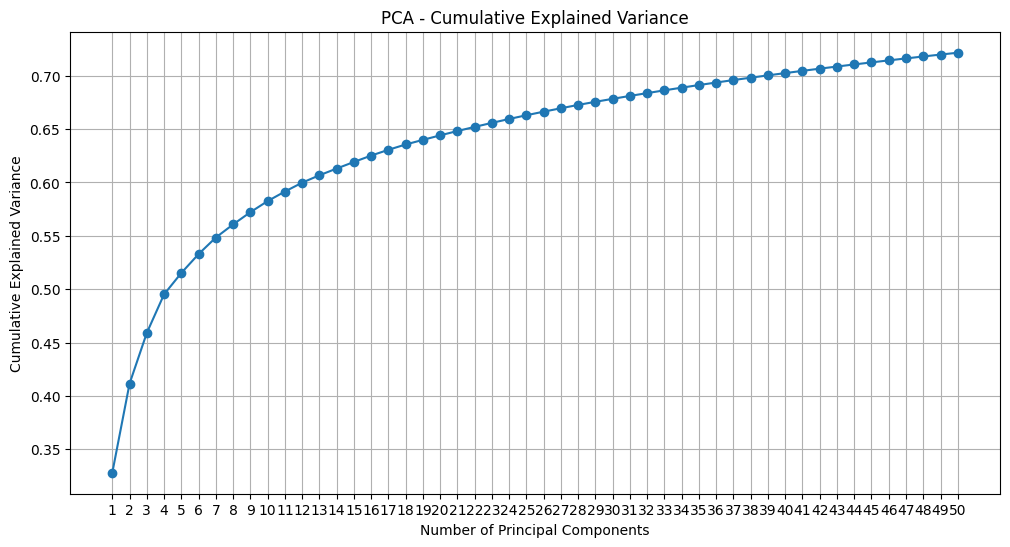

In [8]:
# Perform PCA
pca = PCA()
pca.fit(hog_features_array_train)

# Plot the cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Min number of principal components to plot
num_components = min(50, len(cumulative_explained_variance))
components_range = np.arange(1, num_components + 1)

plt.figure(figsize=(12, 6))
plt.plot(components_range, cumulative_explained_variance[components_range - 1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [11]:
# Initialize the logistic regression model
logreg_model = LogisticRegression()

# Train the logistic regression model
logreg_model.fit(hog_features_array_train, y_train_collected)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [12]:
# Now, let's prepare the test data and evaluate the model
hog_features_list_test = []
y_test_collected = []
for i in range(len(test_generator.filenames)):
    image_path = test_generator.filepaths[i]
    suit_image, _ = detect_suit_regions_with_box(image_path)
    if suit_image is not None:
        hog_features = compute_hog_features(suit_image)
        hog_features_list_test.append(hog_features)
        y_test_collected.append(test_generator.labels[i])  # Append numerical label

# Convert the list of HOG feature arrays into a 2D array (samples x features).
hog_features_array_test = np.vstack(hog_features_list_test)
y_test_collected = np.array(y_test_collected)

No suit regions detected for Dataset/train/ten of diamonds/005.jpg
No suit regions detected for Dataset/test/three of diamonds/5.jpg
No suit regions detected for Dataset/valid/eight of hearts/3.jpg
No suit regions detected for Dataset/train/ten of spades/011.jpg
No suit regions detected for Dataset/test/two of spades/4.jpg
No suit regions detected for Dataset/test/four of hearts/3.jpg
No suit regions detected for Dataset/train/five of diamonds/003.jpg
No suit regions detected for Dataset/valid/three of hearts/2.jpg


In [13]:
# Make predictions on the test set
y_pred = logreg_model.predict(hog_features_array_test)

# Evaluate the model
accuracy = accuracy_score(y_test_collected, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.3335419274092616


In [ ]:
def preprocess_image(image_array):
    # Convert the image to grayscale if it's in color
    if image_array.shape[-1] == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(image_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return adaptive_thresh

def detect_suit_regions_with_box(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to grayscale and apply adaptive thresholding
    suit_image = preprocess_image(image_rgb)

    # Convert the image to binary using Otsu's thresholding.
    # Otsu's thresholding divides the pixels of the image into two classes: foreground and background.
    # Helps isolate region of interest for feature extraction
    _, binary_image = cv2.threshold(suit_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Erode the binary image to enhance the suits.
    # Eroding reduces the size of the white regions of the foreground.
    eroded_image = cv2.erode(binary_image, None, iterations=2)

    # Find contours, the outlines that have the same intensity, in the eroded image.
    contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours are detected.
    # If not, then return None
    if not contours:
        print(f"No suit regions detected for {image_path}")
        return None, None

    # Find the largest contour, assuming it corresponds to the suit region.
    suit_contour = max(contours, key=lambda x: cv2.contourArea(x))

    # Get the bounding box of the suit contour.
    x, y, w, h = cv2.boundingRect(suit_contour)

    # Draw bounding box on the original image
    suit_image_with_box = image_rgb.copy()
    cv2.rectangle(suit_image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop the suit region from the original image.
    suit_image_cropped = suit_image[y:y + h, x:x + w]

    return suit_image_cropped, suit_image_with_box

In [14]:
# Display sample images

def plot_sample_image_with_box(image_path):
    suit_image_cropped, suit_image_with_box = detect_suit_regions_with_box(image_path)

    if suit_image_cropped is not None:
        # Plot the original image with the bounding box
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.imread(image_path))
        plt.title("Original Image with Bounding Box")
        plt.axis('off')

        # Plot the cropped suit region
        plt.subplot(1, 2, 2)
        plt.imshow(suit_image_cropped, cmap='gray')
        plt.title("Cropped Suit Region")
        plt.axis('off')

        plt.show()

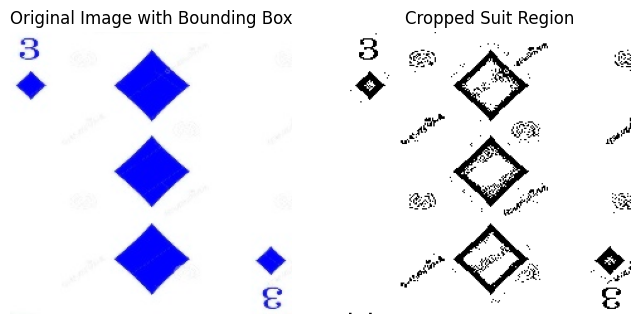

In [15]:
# Replace 'image_path' with the actual file path of the image you want to plot
plot_sample_image_with_box('Dataset/train/three of diamonds/006.jpg')